In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

In [2]:
# Load the data
calendar_df = pd.read_csv('data/calendar_preprocessed.csv')
gps_data_df = pd.read_csv('data/gps_data_preprocessed.csv')
roster_df = pd.read_csv('data/roster_preprocessed.csv')
wellness_df = pd.read_csv('data/wellness_preprocessed.csv')

In [3]:
# Merge relevant dataframes (GPS data and Wellness data)
merged_df = pd.merge(gps_data_df, wellness_df, on=['Player Name', 'Session Date'], how='inner')

# Add a new feature indicating performance drop (percentage change in total distance)
merged_df['performance_drop'] = merged_df['Total Distance'].pct_change().abs()

# Add a "high_risk" label based on performance drop and high wellness scores (energy, stress, soreness)
merged_df['high_risk'] = merged_df['Soreness'] > 7

# Add a new column "High Speed Running" based on the sum of "Distance Zone 5" and "Distance Zone 6"
merged_df['High Speed Running'] = merged_df['Distance Zone 5'] + merged_df['Distance Zone 6']

merged_df.head()

,Player Name,Session Date,Drill Name,Session Time(mins),Total Distance,Metres Per Minute,Distance Zone 1,Distance Zone 2,Distance Zone 3,Distance Zone 4,...,HML Efforts,Explosive Distance,Energy,Sleep Quality,Stress,Soreness,Total Score,performance_drop,high_risk,High Speed Running
0,Vinicius Jr,2022-09-01,Crossing & Finishing,29.45,2052.0,69.66,577.0,680.0,561.0,231.0,...,26.0,179,10,10,10,9,39,NaN,True,3.0
1,Mariano,2022-09-01,Crossing & Finishing,29.45,1395.0,47.36,666.0,461.0,152.0,104.0,...,22.0,162,9,8,7,8,32,0.320175,True,11.0
2,Camavinga,2022-09-15,Crossing & Finishing,30.40,1576.0,51.85,831.0,344.0,171.0,148.0,...,40.0,213,9,9,9,8,35,0.129749,True,82.0
3,Ceballos,2022-09-15,Crossing & Finishing,4.61,141.0,30.56,76.0,41.0,11.0,12.0,...,2.0,15,7,6,9,9,31,0.910533,True,0.0
4,Carvajal,2022-09-15,Crossing & Finishing,30.40,1370.0,45.05,630.0,379.0,174.0,167.0,...,21.0,180,8,8,8,8,32,8.716312,True,19.0


In [4]:
# Select relevant features for training the model
features = merged_df[['Total Distance', 'Metres Per Minute','High Speed Running',
                    'performance_drop', 'Energy', 'Soreness', 'Stress']]

# Set the target variable: 'high_risk' (1 = high injury risk, 0 = low risk)
target = merged_df['high_risk']

In [5]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Display the sizes of the train and test sets
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 170 samples
Test set size: 43 samples


In [6]:
from imblearn.over_sampling import SMOTE

X_train_filled = pd.DataFrame(X_train).fillna(pd.DataFrame(X_train).median())
X_test_filled = pd.DataFrame(X_test).fillna(pd.DataFrame(X_test).median())

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filled)
X_test_scaled = scaler.transform(X_test_filled)

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score


# Fit the RandomForest model
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_scaled, y_train)


y_pred = rf.predict(X_test_scaled)

In [8]:
# Evaluate the model's performance using accuracy, precision, recall, F1 score, and ROC AUC
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")


Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
ROC AUC: 1.00


[[27  0]
 [ 0 16]]


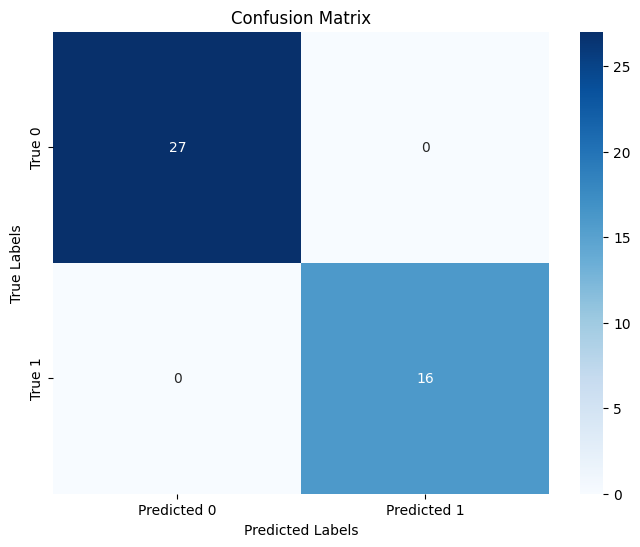

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print(cm)


# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))  # Set the size of the plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


In [14]:
import pickle

with open('injury_risk_model.pkl', 'wb') as model_file:
    pickle.dump(rf, model_file)  # Use rf instead of rf_model